In [4]:
%load_ext tensorboard

In [1]:
import os
import base64
import imageio
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import IPython
import pyvirtualdisplay
from tqdm import tqdm
from datetime import datetime

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameters

In [2]:
num_iterations = 20000
initial_collect_steps = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000
batch_size = 64
learning_rate = 1e-3
log_interval = 200
num_eval_episodes = 10
eval_interval = 1000

## Environment

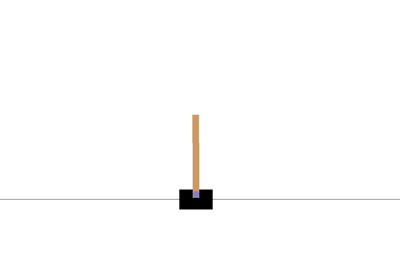

In [16]:
env_name = "CartPole-v1"

env = suite_gym.load(env_name)
env.reset()
img = Image.fromarray(env.render('rgb_array'))
img.resize((img.width//3, img.height//3))

In [9]:
print("Observation Spec:\n", env.time_step_spec().observation, '\n')
print("Reward Spec:\n", env.time_step_spec().reward, '\n')
print("Action Spec:\n", env.action_spec(), '\n')

Observation Spec:
 BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]) 

Reward Spec:
 ArraySpec(shape=(), dtype=dtype('float32'), name='reward') 

Action Spec:
 BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1) 



In [3]:
# Create two environments and convert them into tensor compatible
env_name = "CartPole-v1"

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

print("python:\n", train_py_env.time_step_spec())
print("tf:\n", train_env.time_step_spec())

python:
 TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]))
tf:
 TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887

## Agent

In [4]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(100,),
)

In [5]:
optimizer = tf.optimizers.Adam(learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_net,
    optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
)
agent.initialize()

In [6]:
# Sample step
time_step = train_env.reset()
action_step = agent.collect_policy.action(time_step)
time_step = train_env.step(action_step.action)

## Metrics and Evaluation

In [42]:
def compute_avg_return(env, policy, num_episodes=10):
    total_return = 0.
    for _ in range(num_episodes):
        time_step = env.reset()
        episode_return = 0.
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = env.step(action_step.action)
            episode_return += time_step.reward.numpy()[0]
            
        total_return += episode_return
        
    return total_return / num_episodes
            

In [43]:
compute_avg_return(eval_env, agent.policy, num_eval_episodes)

9.5

## Replay Buffer

In [8]:
print(agent.collect_data_spec._fields)
print("\n", agent.collect_data_spec)

('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')

 Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))


In [50]:
train_env.batch_size

1

In [110]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length,
)

## Train

In [59]:
time_step = train_env.current_time_step()
action_step = agent.collect_policy.action(time_step)
next_time_step = train_env.step(action_step.action)
traj = trajectory.from_transition(time_step, action_step, next_time_step)

print(traj._fields)
print("observation: ", traj.observation)
print("next_step_type: ", traj.next_step_type)

('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')
observation:  tf.Tensor([[-0.03980492 -1.1492302   0.10183977  1.829516  ]], shape=(1, 4), dtype=float32)
next_step_type:  tf.Tensor([1], shape=(1,), dtype=int32)


In [64]:
def collect_step(env, policy, buffer):
    time_step = env.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = env.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)
    
    
def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)
        
        

In [112]:
collect_data(train_env, agent.collect_policy, replay_buffer, steps=100)

In [73]:
train_data = iter(replay_buffer.as_dataset()).next()
print(train_data[0], '\n', train_data[0]._fields, '\n')
print(train_data[1])

Trajectory(step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, observation=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.07608635, -0.95248616,  0.0194587 ,  1.381734  ], dtype=float32)>, action=<tf.Tensor: shape=(), dtype=int64, numpy=0>, policy_info=(), next_step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, discount=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>) 
 ('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount') 

BufferInfo(ids=<tf.Tensor: shape=(), dtype=int64, numpy=30>, probabilities=<tf.Tensor: shape=(), dtype=float32, numpy=0.01>)


In [89]:
# Generate dataset from replay buffer
dataset = replay_buffer.as_dataset(
    sample_batch_size=batch_size,
    num_steps=2,
    num_parallel_calls=3,
)
dataset

<ParallelMapDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [94]:
iterator = iter(dataset)
experiences, _ = iterator.next() 
print(experiences._fields)
print("observation shape: ", experiences.observation.shape)

loss_info = agent.train(experiences)
print('\nLoss Info: ', loss_info._fields)
print(loss_info.loss)

('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')
observation shape:  (64, 2, 4)

Loss Info:  ('loss', 'extra')
tf.Tensor(0.9262797, shape=(), dtype=float32)


### Training Code

In [115]:
# Training code

# Create log directory
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("logs", "DQN", current_time)
summary_writer = tf.summary.create_file_writer(logdir)


agent.train = common.function(agent.train)

agent.train_step_counter.assign(0)


replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length,
)

dataset = replay_buffer.as_dataset(
    sample_batch_size=batch_size,
    num_steps=2,
    num_parallel_calls=3,
)
iterator = iter(dataset)

# Evaluate the agent policy before training
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
with summary_writer.as_default():
    tf.summary.scalar("Avg Return", avg_return, step=0)
    tf.summary.scalar("Avg Return - Step", avg_return, step=0)

    
# Collect initial data
collect_data(train_env, agent.collect_policy, replay_buffer, initial_collect_steps)


for i in tqdm(range(num_iterations)):
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)
        
    experiences, _ = next(iterator)
    train_loss = agent.train(experiences).loss
    with summary_writer.as_default():
        tf.summary.scalar("Loss", train_loss, step=i)
        
    
    if i % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        with summary_writer.as_default():
            tf.summary.scalar("Avg Return", avg_return, step=i)
            tf.summary.scalar("Avg Return - Step", avg_return, step=replay_buffer.num_frames().numpy())


100%|██████████| 20000/20000 [04:18<00:00, 77.42it/s] 


%tensorboardplay video

In [117]:
%tensorboard --logdir logs/DQN

Reusing TensorBoard on port 6006 (pid 56511), started 0:04:16 ago. (Use '!kill 56511' to kill it.)

## Visualize as Video

In [123]:
def embed_mp4(filename):
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        # Run policy
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
                
    return embed_mp4(filename)

In [124]:
create_policy_eval_video(agent.policy, "logs/DQN/20200705-032112/performance.mp4")